In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F
import copy
from PIL import Image
import matplotlib.pyplot as plt
import json
from collections import OrderedDict
from PIL import Image
import seaborn as sns

In [14]:
data_dir = '/media/jatin/Work/Datasets/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

In [17]:
image_datasets = dict()
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=valid_transforms)
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=test_transforms)

batch_size = 8

dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size)
dataloaders['test']  = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes
n_class = len(class_names)

print ("Dasaset Size: "+ str(dataset_sizes) + "\n")
print ("Number of classes: "+ str(n_class) + "\n")

Dasaset Size: {'train': 6552, 'valid': 818, 'test': 819}

Number of classes: 102



In [46]:
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

In [19]:
vgg16 = models.vgg16(pretrained=True)
#print(model)

for param in vgg16.parameters():
    param.requires_grad = False
    
num_features = vgg16.classifier[0].in_features

classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(num_features, 512)),
                              ('relu', nn.ReLU()),                    
                              ('fc2', nn.Linear(512, 102)),
                              ('output', nn.LogSoftmax(dim=1)),
                              ]))

vgg16.classifier = classifier
#print(model)

In [20]:
def train_model(model, criteria, optimizer, scheduler, num_epochs, enabled_device, PATH, resume = False):
    since = time.time()
    
    if resume:
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(enabled_device)
                labels = labels.to(enabled_device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    print("Saving checkpoint....")
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, PATH)
    
    return model

In [22]:
checkpoints = '/media/jatin/Work/Jupyter/deep-learning-v2-pytorch-master/pytorch_challenge-master/checkpoints/vgg16.pt'

num_epochs = 10

if torch.cuda.is_available():
    print ("Using GPU: ")
    vgg16 = vgg16.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

vgg16 = train_model(vgg16, criterion, optimizer, exp_lr_scheduler, num_epochs, device, checkpoints, True)

Using GPU: 
Epoch 0/9
----------
train Loss: 1.2279 Acc: 0.6786
valid Loss: 0.7619 Acc: 0.7983

Epoch 1/9
----------
train Loss: 1.1486 Acc: 0.7045
valid Loss: 0.8467 Acc: 0.8044

Epoch 2/9
----------
train Loss: 1.1092 Acc: 0.7140
valid Loss: 0.7965 Acc: 0.8240

Epoch 3/9
----------
train Loss: 1.0637 Acc: 0.7331
valid Loss: 0.7467 Acc: 0.8313

Epoch 4/9
----------
train Loss: 0.7891 Acc: 0.7837
valid Loss: 0.5420 Acc: 0.8802

Epoch 5/9
----------
train Loss: 0.7276 Acc: 0.8062
valid Loss: 0.5131 Acc: 0.8888

Epoch 6/9
----------
train Loss: 0.6376 Acc: 0.8284
valid Loss: 0.5171 Acc: 0.8912

Epoch 7/9
----------
train Loss: 0.6732 Acc: 0.8237
valid Loss: 0.5032 Acc: 0.8851

Epoch 8/9
----------
train Loss: 0.6222 Acc: 0.8423
valid Loss: 0.4928 Acc: 0.8875

Epoch 9/9
----------
train Loss: 0.6146 Acc: 0.8378
valid Loss: 0.4870 Acc: 0.8863

Training complete in 25m 49s
Best val Acc: 0.891198
Saving checkpoint....


In [23]:
def test_accuracy(model, data):
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    model.eval()  
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):

            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # obtain the outputs from the model
            outputs = model.forward(inputs)

            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)

            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            equals = predicted == labels.data

            if idx == 0:
                print(equals)

            print(equals.float().mean())

In [24]:
test_accuracy(vgg16, 'test')

tensor([ 0,  0,  0, 13,  0,  1,  1,  1], device='cuda:0')
tensor([0.9846, 0.9963, 0.7237, 0.3604, 0.6215, 0.9718, 0.9985, 0.9999],
       device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')


In [27]:
vgg16.class_to_idx = image_datasets['train'].class_to_idx
vgg16.cpu()
torch.save({'state_dict': vgg16.state_dict(), 
            'class_to_idx': vgg16.class_to_idx}, 
            '/media/jatin/Work/Jupyter/deep-learning-v2-pytorch-master/pytorch_challenge-master/vgg16.pt')


In [34]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    vgg16 = models.vgg16()
    num_features = vgg16.classifier[0].in_features
    
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(num_features, 512)),
                              ('relu', nn.ReLU()),                    
                              ('fc2', nn.Linear(512, 102)),
                              ('output', nn.LogSoftmax(dim=1)),
                              ]))
    
    vgg16.classifier = classifier
    vgg16.load_state_dict(checkpoint['state_dict'])
    
    return vgg16, checkpoint['class_to_idx']

In [35]:
vgg16_trained, class_to_idx = load_checkpoint('/media/jatin/Work/Jupyter/deep-learning-v2-pytorch-master/pytorch_challenge-master/vgg16.pt')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [36]:
test_accuracy(vgg16_trained, 'test')

tensor([ 0,  0,  0, 13,  0,  1,  1,  1], device='cuda:0')
tensor([0.9846, 0.9963, 0.7237, 0.3604, 0.6215, 0.9718, 0.9985, 0.9999],
       device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8750, device='cuda:0')


In [69]:
image_path = '/media/jatin/Work/Datasets/flowers/test/1/image_06743.jpg'

In [70]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    img = Image.open(image_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))

    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224

    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [71]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    if title:
        plt.title(title)

    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

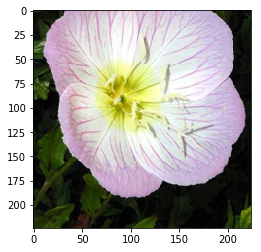

In [72]:
img = process_image(image_path)
imshow(img)

In [73]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    model = model.cpu()
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)

    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      class_to_idx.items()}

    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]

    return top_probs, top_labels, top_flowers

In [74]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    flower_num = image_path.split('/')[-2]
    title_ = label_map[flower_num]

    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);

    # Make prediction
    probs, labs, flowers = predict(image_path, model) 

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

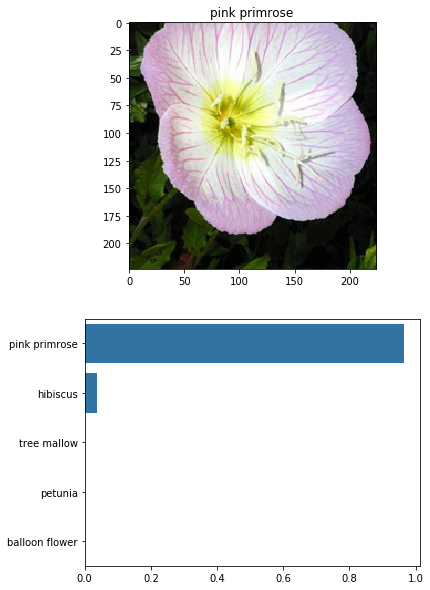

In [75]:
plot_solution(image_path, vgg16_trained)